In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np
from qiskit.primitives import Sampler,Estimator
import pickle 
import time
from qiskit.circuit.library import iSwapGate


In [2]:
J=1
nQ=3
n_qubits=3*nQ
sqrt_iSWAP = iSwapGate().power(1/2)

In [3]:
def add3Q(circuit,tmpIndex,alpha=J):
    tmpIndex1=(tmpIndex+1)%(n_qubits)
    tmpIndex2=(tmpIndex+2)%(n_qubits)
    
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    #circuit.barrier()
    circuit.rz(np.pi,tmpIndex)
    circuit.rz(-np.pi/4,tmpIndex1)
    circuit.rz(-np.pi/4,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    
    circuit.rz(np.pi-alpha,tmpIndex1)
    circuit.rz(alpha,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    circuit.rz(np.pi/4,tmpIndex1)
    circuit.rz(np.pi/4,tmpIndex2)
    #circuit.barrier()
            
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    
    

In [41]:
def getTrotterCircuit(n_qubits,J,nTrotter=2,fFactor=0.2,dtFactor=0.2):
    f=fFactor*J
    dt=dtFactor/J
    
    circuit = QuantumCircuit(n_qubits)
    #circuit = QuantumCircuit(n_qubits,n_qubits)
    
    center_index=np.ceil((n_qubits-1)/2)
    if center_index%2==1:
        center_index+=1
    
    #First produce the initial state:
    for i in range(n_qubits):
   
        if i!=center_index:
            if i%2!=0:
                circuit.h(i)
                
            else:
                circuit.x(i)
 
    #Trotterization:
    for step in range(nTrotter):
        
        circuit.barrier()
        
        
        
        for i in range(int(n_qubits/4)):
            tmpIndex=i*4
            add3Q(circuit,tmpIndex,alpha=J*dt)
        circuit.barrier()
        
        n_end=1 # no period
        for i in range(int(n_qubits/4)):
            tmpIndex=i*4+2
            add3Q(circuit,tmpIndex,alpha=J*dt)
        circuit.barrier()
        
        
        
        for i in range(int(n_qubits/3)):
            tmpIndex=i*3
            circuit.rz(0,tmpIndex)
            circuit.rx(f*dt,tmpIndex+1)
            circuit.rz(0,tmpIndex+2)
            
    return circuit
    
    
    

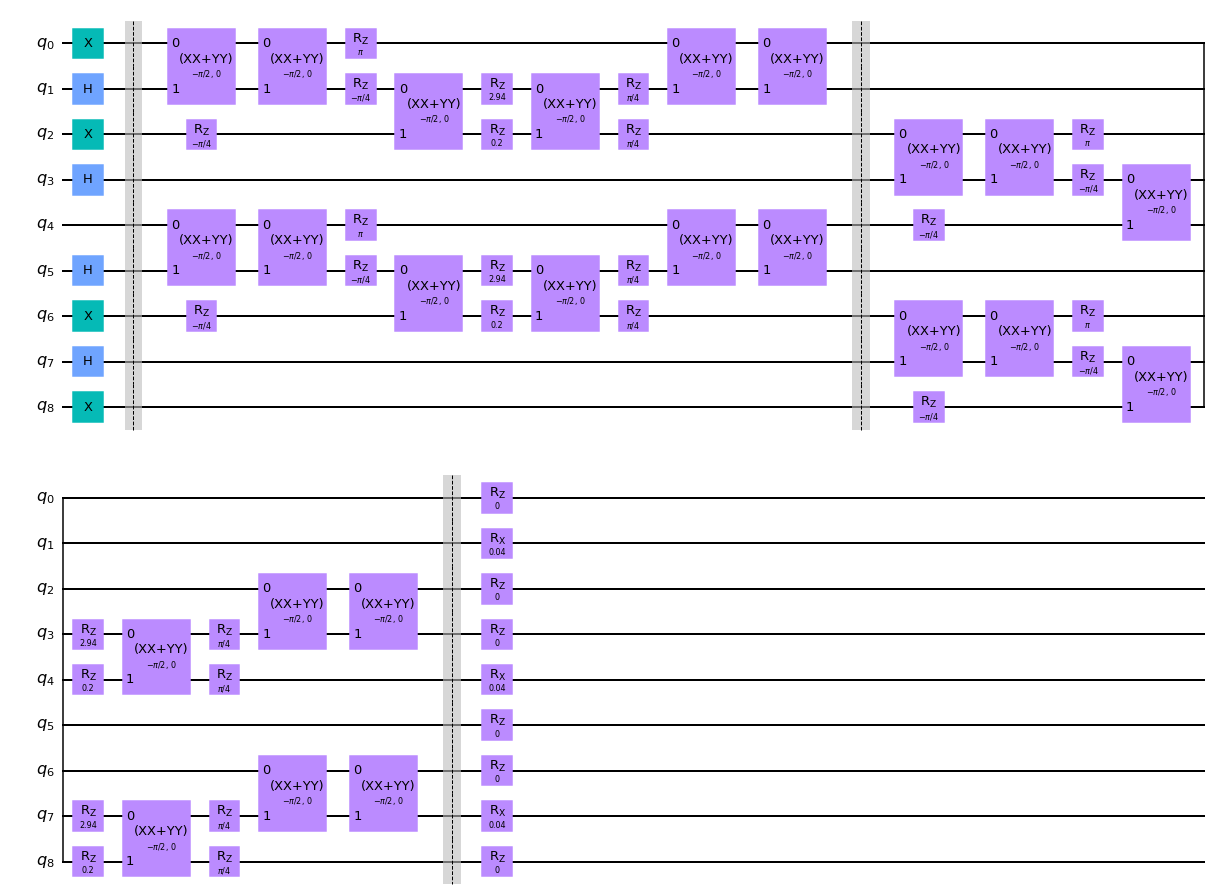

In [42]:
circuit = getTrotterCircuit(n_qubits,J,nTrotter=1)
circuit.draw('mpl')

In [43]:
observable_list=[]
for i in range(n_qubits):
    if i%2!=0:
        observable=SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(n_qubits-i-1) , 1)])
        observable_list.append(observable)
        
    else:
  
        observable=SparsePauliOp.from_list([("I"*(i)+"Z"+"I"*(n_qubits-i-1) , -1)])
        observable_list.append(observable)
print(observable_list)


[SparsePauliOp(['ZIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IXIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIXIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIZIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIXIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIZII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIXI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIZ'],
              coeffs=[-1.+0.j])]


In [44]:
dtFactor=0.2
nSteps=30

<Figure size 432x288 with 0 Axes>

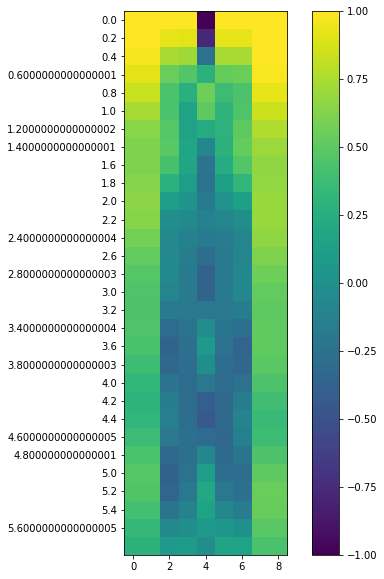

29  steps results =  [ 0.28631935  0.28631935  0.08471731  0.0970216  -0.01225524  0.16550363
  0.1634634   0.42698356  0.42698356]
time taken =  0.48546314239501953


In [47]:
estimator=Estimator()
results_list_2=[]
for i in range(nSteps):
    t_start=time.time()
    circuit = getTrotterCircuit(n_qubits,J,nTrotter=i,fFactor=2,dtFactor=dtFactor)

    job=estimator.run(circuits=[circuit]*len(observable_list), observables=observable_list,shots=None)
    results=np.array(job.result().values)
    results_list_2.append(results)
    #print(i)   
    
    clear_output(wait=True)
    plt.figure(1)
    plt.figure(figsize=(9,10))
    plt.imshow(results_list_2, interpolation='none')
    plt.colorbar()
    y=dtFactor*J*np.arange(0,i,1)
    plt.yticks(range(len(y)), y)
    plt.show()
    print(i," steps results = ",results)
    print("time taken = ",time.time()-t_start)
    
results_list_2=np.array(results_list_2)

<Figure size 432x288 with 0 Axes>

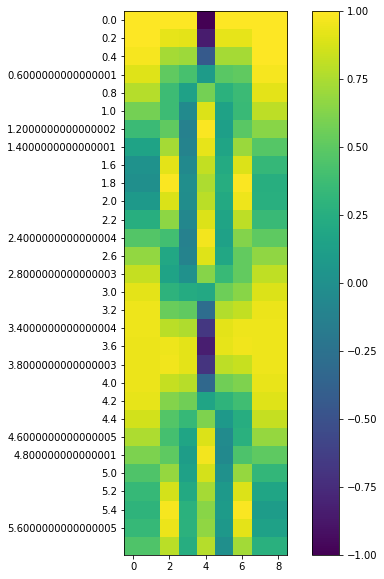

29  steps results =  [ 0.45280321  0.45280321  0.78963571  0.24472743  0.7745942  -0.00287147
  0.7228311   0.27024368  0.27024368]
time taken =  0.49176692962646484


In [46]:
estimator=Estimator()
results_list_2en2=[]

for i in range(nSteps):
    t_start=time.time()
    circuit = getTrotterCircuit(n_qubits,J,nTrotter=i,fFactor=0.2,dtFactor=dtFactor)
    job=estimator.run(circuits=[circuit]*len(observable_list), observables=observable_list,shots=None)
    results=np.array(job.result().values)
    results_list_2en2.append(results)
    
    
    clear_output(wait=True)
    plt.figure(1)
    plt.figure(figsize=(9,10))
    plt.imshow(results_list_2en2, interpolation='none')
    plt.colorbar()
    y=dtFactor*J*np.arange(0,i,1)
    plt.yticks(range(len(y)), y)
    plt.show()
    print(i," steps results = ",results)
    print("time taken = ",time.time()-t_start)
    
results_list_2en2=np.array(results_list_2en2)

In [56]:
nQ=7
n_qubits=3*nQ

observable_list=[]
for i in range(n_qubits):
    if i%2!=0:
        observable=SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(n_qubits-i-1) , 1)])
        observable_list.append(observable)
        
    else:
  
        observable=SparsePauliOp.from_list([("I"*(i)+"Z"+"I"*(n_qubits-i-1) , -1)])
        observable_list.append(observable)
print(observable_list)


[SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IXIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZIIIIIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIXIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIZIIIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIXIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIZIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIXIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIZIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIIIXIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIZIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIIIIIXIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIZIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIXIIIIIII'],
  

In [49]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [50]:
service = QiskitRuntimeService()

In [51]:
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Estimator
from qiskit.providers.fake_provider import FakeManila

backend_realDevice=service.get_backend('ibmq_kolkata')

noise_model = NoiseModel.from_backend(backend_realDevice)

simulator = service.get_backend('ibmq_qasm_simulator')
simulator.set_options(noise_model=noise_model)

simulator_noNoise = service.get_backend('ibmq_qasm_simulator')

In [53]:
# Set options to include the noise model with error mitigation
options0= Options(resilience_level=0)
options1= Options(resilience_level=1)
#options.optimization_level = 0 # no optimization
#options.resilience_level = 0 # M3 for Sampler and T-REx for Estimator

In [54]:
nEvents=1
nShots=2**14
print(nShots)

16384


In [57]:
job_2en2_list=[]

with Session(service=service, backend=simulator) as session:
    estimator = Estimator(session=session,options=options0)
    
    for i in range(nSteps):

        circuit = getTrotterCircuit(n_qubits,J,nTrotter=i,fFactor=0.2,dtFactor=dtFactor)
        job=estimator.run(circuits=[circuit]*len(observable_list), observables=observable_list,shots=nShots)
        job_2en2_list.append(job)
    
    print("finished")

finished


In [58]:
job.result()

EstimatorResult(values=array([ 0.77099609,  0.7668457 ,  0.79516602,  0.56237793,  0.76782227,
        0.34228516,  0.98669434,  0.35192871,  0.74291992,  0.13903809,
        0.94311523, -0.10205078,  0.74865723,  0.11462402,  0.98181152,
        0.12451172,  0.76733398,  0.34399414,  0.60546875,  0.72705078,
        0.72668457]), metadata=[{'variance': 0.4055650234222412, 'shots': 16384}, {'variance': 0.41194766759872437, 'shots': 16384}, {'variance': 0.36771100759506226, 'shots': 16384}, {'variance': 0.6837310642004013, 'shots': 16384}, {'variance': 0.41044896841049194, 'shots': 16384}, {'variance': 0.8828408718109131, 'shots': 16384}, {'variance': 0.026434287428855896, 'shots': 16384}, {'variance': 0.8761461824178696, 'shots': 16384}, {'variance': 0.4480699896812439, 'shots': 16384}, {'variance': 0.9806684106588364, 'shots': 16384}, {'variance': 0.11053365468978882, 'shots': 16384}, {'variance': 0.9895856380462646, 'shots': 16384}, {'variance': 0.43951235711574554, 'shots': 16384}, 

<Figure size 432x288 with 0 Axes>

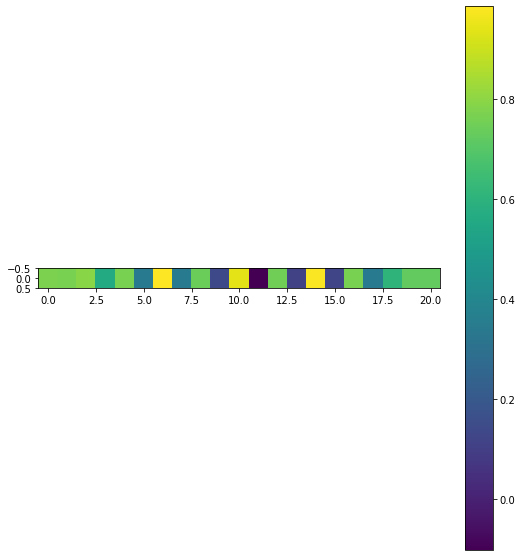

In [59]:
plt.figure(1)
plt.figure(figsize=(9,10))
results=np.array(job.result().values)
v=[results]
plt.imshow(v, interpolation='none')
plt.colorbar()

plt.show()
    

In [60]:
circuit = getTrotterCircuit(n_qubits,J,nTrotter=13,fFactor=200,dtFactor=dtFactor)

with Session(service=service, backend=simulator) as session:
    estimator = Estimator(session=session,options=options0)
    job2=estimator.run(circuits=[circuit]*len(observable_list), 
                                        observables=observable_list,shots=nShots)
    print("finished")

finished


<Figure size 432x288 with 0 Axes>

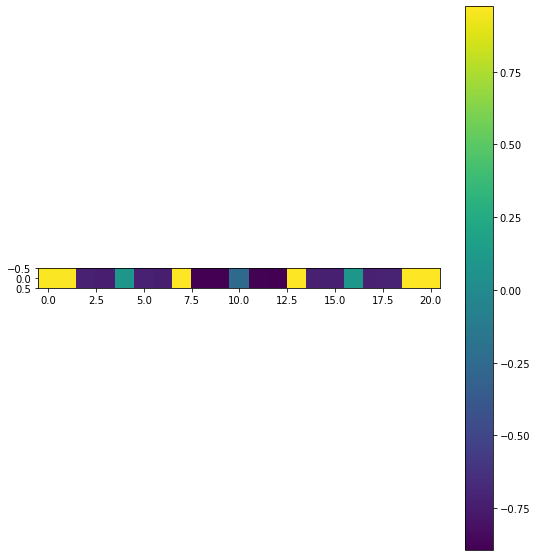

In [61]:
plt.figure(1)
plt.figure(figsize=(9,10))
results=np.array(job2.result().values)
v=[results]
plt.imshow(v, interpolation='none')
plt.colorbar()

plt.show()
    